In [524]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [525]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [526]:
import torch
import torch.nn as nn

In [527]:
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive

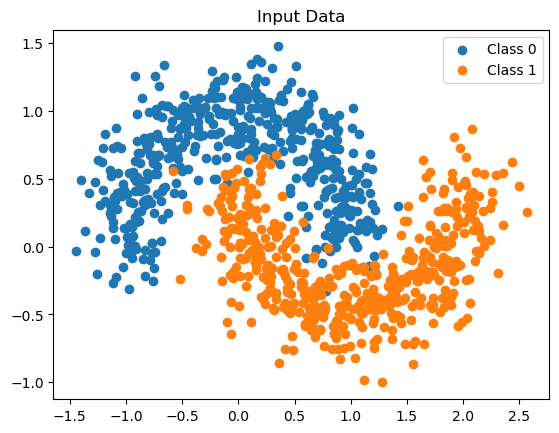

In [528]:
#Make data
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
plt.scatter(X[y==0,0],X[y==0,1],label='Class 0')
plt.scatter(X[y==1,0],X[y==1,1],label='Class 1')
plt.title('Input Data')
plt.legend()
plt.show()


In [529]:
scalar = StandardScaler()
X = scalar.fit_transform(X)


In [530]:
print(len(X),len(y))

1000 1000


In [531]:
#Splitting the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [532]:
X_train = torch.tensor(X_train, dtype=torch.float32) 
y_train = torch.tensor(y_train, dtype=torch.float32) 
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [533]:
#Creating bayesian Network

class BNN(nn.Module):
    def __init__(self):
        super(BNN, self).__init__()
        #two hidden layers with 8 neurons
        self.hidden1 = nn.Linear(2, 8)
        self.hidden2 = nn.Linear(8, 8)
        self.out = nn.Linear(8, 1)


    def forward(self, x, weights):
        h1 = torch.relu(torch.addmm(weights['b1'], x, weights['w1'])) #addmm multiplies the imput with the weight and then adds the bias
        h2 = torch.relu(torch.addmm(weights['b2'], h1, weights['w2']))
        out = torch.sigmoid(torch.addmm(weights['b3'], h2, weights['w3']))
        return out.squeeze()

In [534]:
def model(x_data, y_data=None):
    #For each sample run, NUTS sampler will call this model multiple times. Each time it calls the model,
    #it will estimate how well the sampled weights are able to produce the output close to y_train
    #and compares it with the previous iteration. If they proposed iteration (i.e., weights/biases) provide a better fit 
    #compared to the previous one, it will reject the previous sampled weights/biases and hold on the current ones and repeats the process
    
    w1 = pyro.sample("w1", dist.Normal(torch.zeros(2, 8), torch.ones(2, 8)))
    b1 = pyro.sample("b1", dist.Normal(torch.zeros(8), torch.ones(8)))
    w2 = pyro.sample("w2", dist.Normal(torch.zeros(8, 8), torch.ones(8)))
    b2 = pyro.sample("b2", dist.Normal(torch.zeros(8), torch.ones(8)))
    w3 = pyro.sample("w3", dist.Normal(torch.zeros(8, 1), torch.ones(8, 1)))
    b3 = pyro.sample("b3", dist.Normal(torch.zeros(1), torch.ones(1)))

    
    #print(w1)
    

    weights = {'w1': w1, 'b1': b1, 'w2': w2, 'b2': b2, 'w3': w3, 'b3': b3}

    

    logits = BNN()(x_data, weights) #logits are the model's raw predictions before they are transformed into probabilities via the 
                                    #sigmoid function

    #print(f"HI: {len(logits)}")

    
    

    d = pyro.sample("obs", dist.Bernoulli(logits), obs=y_data)
    #print(f"d: {len(d)}")
    #print()

    """
    To understand 'pyro.sample("obs", dist.Bernoulli(logits), obs=y_data)', Suppose our neural network, after processing an input vector X, 
    produces a logit value of 0.8, The logit value is converted to a probability using the Bernoulli distribution (for binay classification)
    which is p = 1/(1+e^(logit)). This probability is then converted to a Likelihood with the equation Likelihood = p^y x (1-p)^(1-y)
    where y is the y_train value for the X input vector. The log-likelihood is calculated by taking the log(Likelihood).

    There is no loss function when sampling the weight/bias parameters with MCMC. Instead, for a given sample of weights and biases
    the log likelihood is esitamted. if the log likelihood is smaller, it would indicate that the model's predictions are less aligned 
    to the observed data, meaning a "worse fit." Conversely, a larger log-likelihood indicates a better fit, 
    guiding the model's parameters in the Bayesian inference process. The weigths with the larger log likelihood is usually accepted and
    sampled as a posterior_sample.
    """
    

In [535]:
nuts_kernel = NUTS(model)
#mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200, num_chains=1)
mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=int(0.2*500), num_chains=1)
mcmc.run(X_train, y_train)

Sample: 100%|██| 600/600 [13:41,  1.37s/it, step size=8.99e-03, acc. prob=0.881]


In [536]:
posterior_samples = mcmc.get_samples() #Get the posterior samples
#posterior_samples['b3'], len(posterior_samples['b3']), posterior_samples['w1'], posterior_samples['w1'][0], len(posterior_samples['w1'])


In [537]:
predictive = Predictive(model, posterior_samples, return_sites=["obs"]) #This is the model where the weights are "fixed" which are the 
                                                                        #posterior sample. 
predictions = predictive(X_test)['obs'] #Predictions on the test data




In [538]:
#print((mean_predictions > 0.5).float())
((mean_predictions > 0.5).float() == y_test).float().mean().item(), predictions.ndim, y_test.ndim

(0.5833333134651184, 2, 1)

In [539]:
#accuracy = ((mean_predictions > 0.5).float() == y_test).float().mean().item()
#accuracy_uncertainty = pred_uncertainty.mean().item()
#print(f"Accuracy: {accuracy*100:.2f}% ± {accuracy_uncertainty*100:.2f}%")

accuracies = ((predictions > 0.5).float() == y_test.unsqueeze(0)).float().mean(1)



# Estimate mean accuracy and its credible interval using the beta distribution
alpha = accuracies.mean().item() * len(y_test) + 1
beta = (1 - accuracies.mean().item()) * len(y_test) + 1
#alpha,beta, accuracies.mean().item()
accuracy_mean = accuracies.mean().item()
accuracy_uncertainty = dist.Beta(alpha, beta).stddev.item()

print(f"Accuracy: {accuracy_mean*100:.2f} ± {accuracy_uncertainty*100:.2f}")


Accuracy: 95.52 ± 1.23


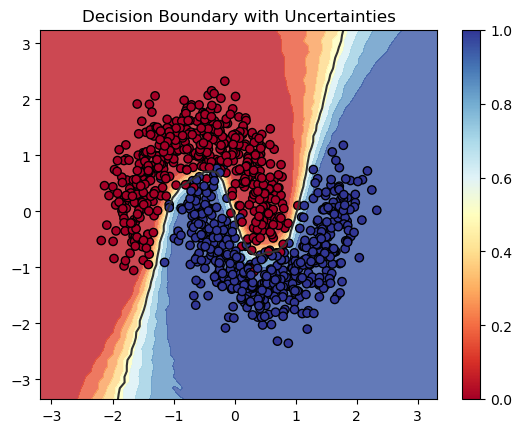

In [540]:
def plot_decision_boundary(predict_fn):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_torch = torch.tensor(grid, dtype=torch.float32)
    pred_mean = predict_fn(grid_torch)['obs'].mean(0).reshape(xx.shape)
    pred_std = predict_fn(grid_torch)['obs'].std(0).reshape(xx.shape)
    
    plt.contourf(xx, yy, pred_mean, alpha=0.8, levels=np.linspace(0, 1, 10), cmap='RdYlBu')
    plt.contour(xx, yy, pred_mean, levels=[0.5], cmap='Greys', vmin=0, vmax=.6)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu', edgecolors='k')
    plt.colorbar()
    plt.title("Decision Boundary with Uncertainties")
    plt.show()

plot_decision_boundary(lambda x: Predictive(model, posterior_samples)(x))

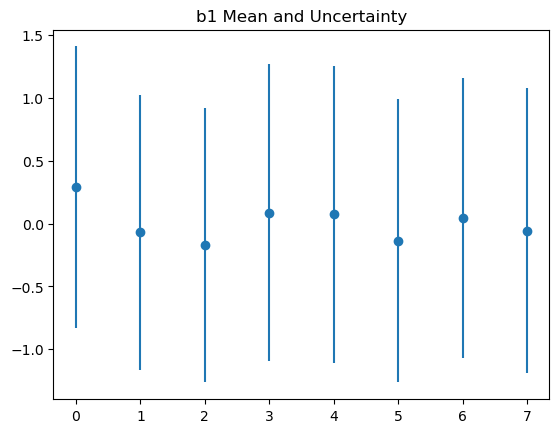

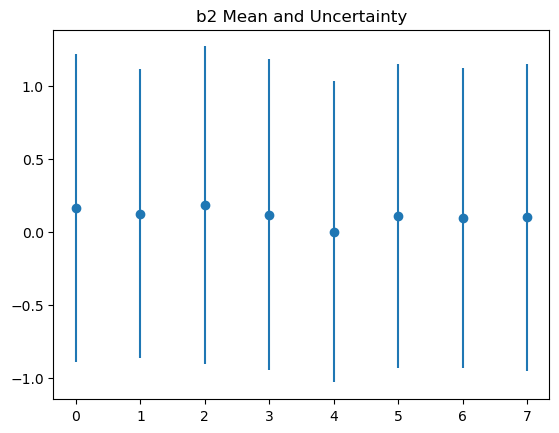

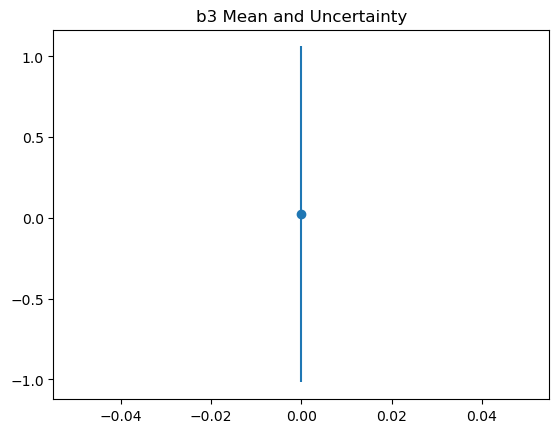

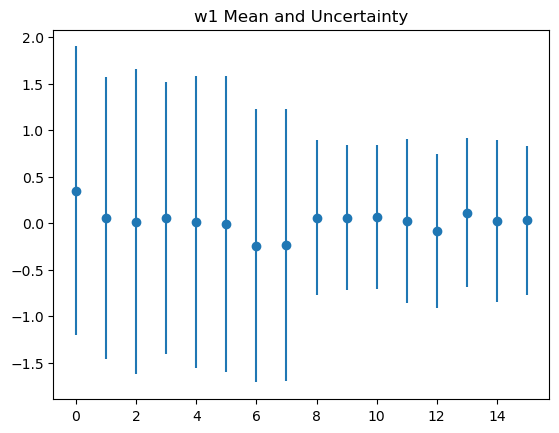

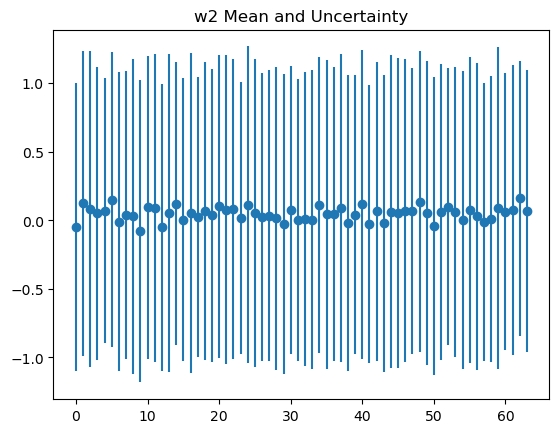

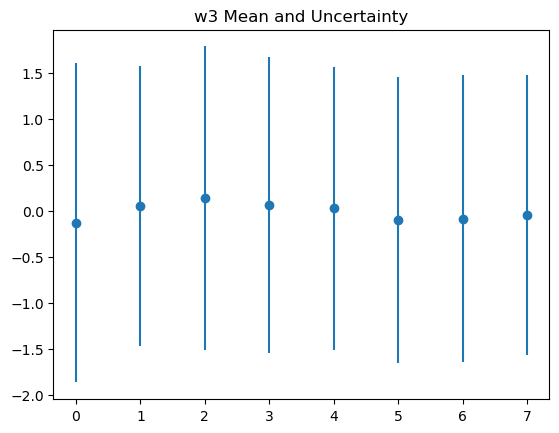

In [541]:
# Plot the mean and uncertainty of weights
for name, param in posterior_samples.items():
    mean_param = param.mean(0).numpy()
    std_param = param.std(0).numpy()
    
    plt.errorbar(np.arange(len(mean_param.flatten())), mean_param.flatten(), yerr=std_param.flatten(), fmt='o', label=name)
    plt.title(f'{name} Mean and Uncertainty')
    plt.show()
